# Materia: Aprendizaje Profundo
## Diplodatos 2019

## Trabajo Práctico Nro 2 -  Redes en escalera avanzadas
### Integrante: Analian Juan Pablo


Este práctico es similar al práctico 1, pero agregará un paso extra que es el uso de redes en escalera avanzadas, ya sean Redes Convolucionales o Redes Recurrentes.

Se les dará, como base, el mismo conjunto de datos de la competencia "PetFinder" que se trabajó para el práctico 1, con el agregado de, en este caso, utilizar la descripción como un feature extra y todo el procesamiento que ello requiere.

Ahora bien, no es el único conjunto de datos que pueden trabajar. Si tienen un conjunto propio de datos que quieran utilizar y dicho conjunto se preste para el uso de alguna red en escalera avanzada (e.g. conjuntos que tengan imágenes o texto), son libres de hacerlo.

In [1]:
import nltk
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras import regularizers

from IPython.display import SVG
from gensim import corpora
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint

nltk.download(["punkt", "stopwords"]);

[nltk_data] Downloading package punkt to /users/jpanalian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /users/jpanalian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Carga de los datos

In [2]:
DATA_DIRECTORY = '../petfinder_dataset/'

In [3]:
dataset = pd.read_csv(os.path.join(DATA_DIRECTORY, 'train.csv'))

target_col = 'AdoptionSpeed'
nlabels = dataset[target_col].unique().shape[0]

dataset.head(3)

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,Description,AdoptionSpeed,PID
0,2,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,Nibble is a 3+ month old ball of cuteness. He ...,2,0
1,1,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,"Good guard dog, very alert, active, obedience ...",2,3
2,1,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,This handsome yet cute boy is up for adoption....,2,4


In [4]:
dataset.shape

(10582, 20)

## Preproceso del texto para agregarlo como feature (manejo de secuencias)

A diferencia del práctico anterior, en este caso es necesario utilizar el texto como feature extra. Pueden luego agregarlo a una red recurrente o convolucional y concatenar su salida a los atributos "escalares" (como "raza" o "género").

A continuación les mostraremos los pasos a seguir para ello. La descripción detallada de para que sirve cada paso se encuentra disponible en el [notebook 3](./3_cnns.ipynb).

### Tokenización

In [5]:
SW = set(stopwords.words("english"))

def tokenize_description(description):
    return [w.lower() for w in word_tokenize(description, language="english") if w.lower() not in SW]

# Fill the null values with the empty string to avoid errors with NLTK tokenization
dataset["TokenizedDescription"] = dataset["Description"].fillna(value="").apply(tokenize_description)

In [6]:
dataset[['Description','PID','TokenizedDescription']].head(2)

,Description,PID,TokenizedDescription
0,Nibble is a 3+ month old ball of cuteness. He ...,0,"[nibble, 3+, month, old, ball, cuteness, ., en..."
1,"Good guard dog, very alert, active, obedience ...",3,"[good, guard, dog, ,, alert, ,, active, ,, obe..."


#### Tamaño de las descripciones

Un punto importante a tener en cuenta es que las descripciones tienen tamaño variable, y esto no es compatible con los algoritmos de aprendizaje automático. Por lo que hay que llevar las secuencias a un tamaño uniforme.

Para definir dicho tamaño uniforme, es útil mirar qué tamaños mínimos, máximos y medios manejan las descripciones y a partir de esto establecer el tamaño máximo de la secuencia.

In [7]:
pprint(dataset["TokenizedDescription"].apply(len).describe())

count    10582.000000
mean        44.419486
std         48.465910
min          0.000000
25%         16.000000
50%         31.000000
75%         55.000000
max        803.000000
Name: TokenizedDescription, dtype: float64


Vemos que más del 75% de las secuencias tienen 55 palabras o menos. Esto es un buen punto de partida, así que podemos establecer el tamaño máximo de las secuencia en 55 palabras.

In [8]:
MAX_SEQUENCE_LEN = 55

## Vocabulario

In [9]:
vocabulary = corpora.Dictionary(dataset["TokenizedDescription"])
vocabulary.filter_extremes(no_below=1, no_above=1.0, keep_n=10000)

In [10]:
list(vocabulary.items())[0:5]

[(0, "'s"), (1, '.'), (2, '3+'), (3, 'ago'), (4, 'ball')]

In [11]:
list(vocabulary.token2id.items())[0:5]

[("'s", 0), ('.', 1), ('3+', 2), ('ago', 3), ('ball', 4)]

## Word Embeddings (GloVe)

In [12]:
embeddings_index = {}

with open("./dataset/glove.6B.100d.txt", "r") as fh:
    for line in fh:
        values = line.split()
        word = values[0]
        if word in vocabulary.token2id:  # Only use the embeddings of words in our vocabulary
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

print("Found {} word vectors.".format(len(embeddings_index)))

Found 7897 word vectors.


## Creación de los datasets

Similar al práctico anterior, tendremos datos que serán "one-hot-encoded", otros serán "embeddings" y otros serán numéricos.

El caso particular del texto es que será tratado como una secuencia de embeddings, y dichos embeddings no serán entrenados en conjunto con la red, sino que serán tomados de un modelo "pre-entrenado". En este caso utilizamos GloVe, pero podríamos haber utilizado otro modelo (e.g. FastText).

In [13]:
# It's important to always use the same one-hot length
one_hot_columns = {
    one_hot_col: dataset[one_hot_col].max()    
    for one_hot_col in ['Type','Gender', 'Color1','Color2', 'Color3','MaturitySize','Vaccinated','Dewormed', 'Sterilized','Health', 'State']
}
embedded_columns = {
    embedded_col: dataset[embedded_col].max() + 1
    for embedded_col in ['Breed1','Breed2'] 
}
numeric_columns = ['Age', 'Fee']

In [14]:
#estandarizamos las columnas numéricas
for num_column in numeric_columns:
        dataset[num_column] =  (dataset[num_column].values  - dataset[num_column].mean()) / dataset[num_column].std()

In [15]:
dataset.head(4)

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,...,Dewormed,Sterilized,Health,Quantity,Fee,State,Description,AdoptionSpeed,PID,TokenizedDescription
0,2,-0.409296,299,0,1,1,7,0,1,1,...,2,2,1,1,1.010113,41326,Nibble is a 3+ month old ball of cuteness. He ...,2,0,"[nibble, 3+, month, old, ball, cuteness, ., en..."
1,1,-0.354871,307,0,2,1,2,0,2,1,...,1,2,1,1,1.647890,41401,"Good guard dog, very alert, active, obedience ...",2,3,"[good, guard, dog, ,, alert, ,, active, ,, obe..."
2,1,-0.518145,307,0,1,1,0,0,2,1,...,2,2,1,1,-0.265443,41326,This handsome yet cute boy is up for adoption....,2,4,"[handsome, yet, cute, boy, adoption, ., playfu..."
3,2,-0.409296,266,0,2,5,6,0,2,1,...,2,2,1,1,-0.265443,41326,This is a stray kitten that came to my house. ...,2,5,"[stray, kitten, came, house, ., feeding, ,, ke..."


## Generador del conjunto de datos

Dada la naturaleza de los datos de texto, y que estos representan una secuencia de datos (que se da luego a una red recurrente o convolucional), en este caso no crearemos los datasets de antemano, sino que los generaremos a medida que el algoritmo de entrenamiento los pida. 

En particular, es porque las secuencias de texto pueden no tener el mismo tamaño (las oraciones tienen diferente cantidad de palabras), pero para que los modelos de redes las acepten, necesitamos rellenarlas (*padding*) de manera que todas tengan el mismo tamaño.

En este paso también vamos a truncar aquellas secuencias de descripciones con más de `MAX_SEQUENCE_LEN` palabras, de manera que al hacer uso de `padded_batch` no lance un error al encontrarse con secuencias de tamaño mayor.

In [16]:
def dataset_generator(ds, test_data=False):
    for _, row in ds.iterrows():
        instance = {}
        
        # One hot encoded features
        instance["direct_features"] = np.hstack([
            tf.keras.utils.to_categorical(row[one_hot_col] - 1, max_value)
            for one_hot_col, max_value in one_hot_columns.items()
        ])
         
         # Agregado por JPA -- Create and append numeric columns 
        for numeric_col in numeric_columns:
            instance[numeric_col] = [row[numeric_col]]
        
        # Embedded features
        for embedded_col in embedded_columns:
            instance[embedded_col] = [row[embedded_col]]
        
        # Document to indices for text data, truncated at MAX_SEQUENCE_LEN words
        instance["description"] = vocabulary.doc2idx(
            row["TokenizedDescription"],
            unknown_word_index=len(vocabulary)
        )[:MAX_SEQUENCE_LEN]
        
        # One hot encoded target for categorical crossentropy
        if not test_data:
            target = tf.keras.utils.to_categorical(row[target_col], nlabels)
            yield instance, target
        else:
            yield instance

# Set output types of the generator (for numeric types check the type is valid)
instance_types = {
    "direct_features": tf.float32,
    "description": tf.int32
}

for embedded_col in embedded_columns:
    instance_types[embedded_col] = tf.int32
    
for numeric_col in numeric_columns:
    instance_types[numeric_col] = tf.float32   
    
                        
tf_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_generator(dataset),
    output_types=(instance_types, tf.int32)
)

for data, target in tf_dataset.take(3):
    pprint(data)
    pprint(target)
    print()
    
# instance_types =  {'direct_features': tf.float32, 'description': tf.int32, 'Breed1': tf.int32, 'Breed2': tf.int32, 'Age': tf.int32, 'Fee': tf.int32}

{'Age': <tf.Tensor: id=43, shape=(1,), dtype=float32, numpy=array([-0.4092958], dtype=float32)>,
 'Breed1': <tf.Tensor: id=44, shape=(1,), dtype=int32, numpy=array([299], dtype=int32)>,
 'Breed2': <tf.Tensor: id=45, shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'Fee': <tf.Tensor: id=46, shape=(1,), dtype=float32, numpy=array([1.0101125], dtype=float32)>,
 'description': <tf.Tensor: id=47, shape=(42,), dtype=int32, numpy=
array([23,  2, 20, 24,  4, 10,  1, 11, 26,  1, 27,  9,  6, 21,  3,  8, 15,
       22, 33,  7, 13, 30,  1, 29, 18, 17,  1, 12, 31, 14,  5,  6, 16,  1,
       19, 28, 25, 32, 23,  0,  5,  1], dtype=int32)>,
 'direct_features': <tf.Tensor: id=48, shape=(41457,), dtype=float32, numpy=array([0., 1., 1., ..., 0., 0., 0.], dtype=float32)>}
<tf.Tensor: id=49, shape=(5,), dtype=int32, numpy=array([0, 0, 1, 0, 0], dtype=int32)>

{'Age': <tf.Tensor: id=50, shape=(1,), dtype=float32, numpy=array([-0.35487115], dtype=float32)>,
 'Breed1': <tf.Tensor: id=51, shape=(1,), 

## Datos de entrenamiento y validación

Ya generado el conjunto de datos base, tenemos que dividirlo en entrenamiento y validación. Además, como vamos a utilizar algunos datos que forman secuencias, los lotes (*batches*) de datos deben estar "rellenados" (*padded_batch*). 

Si bien rellenaremos "todos" los atributos, en la práctica el único que efectivamente se rellenará es el de *description* pues es el único con tamaños distintos.

In [17]:
TRAIN_SIZE = int(dataset.shape[0] * 0.8)
DEV_SIZE = dataset.shape[0] - TRAIN_SIZE
BATCH_SIZE = 128

shuffled_dataset = tf_dataset.shuffle(TRAIN_SIZE + DEV_SIZE, seed=42)

# Pad the datasets to the max value for all the "non sequence" features
padding_shapes = (
    {k: [-1] for k in ["direct_features"] + list(embedded_columns.keys()) + numeric_columns},
    [-1]
)

# Pad to MAX_SEQUENCE_LEN for sequence features
padding_shapes[0]["description"] = [MAX_SEQUENCE_LEN]

# Pad values are irrelevant for non padded data
padding_values = (
    {k: 0 for k in list(embedded_columns.keys()) },
    0
)

for num_col in numeric_columns:
    padding_values[0][num_col] = np.float32(0)

# Padding value for direct features should be a float
padding_values[0]["direct_features"] = np.float32(0)

# Padding value for sequential features is the vocabulary length + 1
padding_values[0]["description"] = len(vocabulary) + 1

train_dataset = shuffled_dataset.skip(DEV_SIZE)\
    .padded_batch(BATCH_SIZE, padded_shapes=padding_shapes, padding_values=padding_values)

dev_dataset = shuffled_dataset.take(DEV_SIZE)\
    .padded_batch(BATCH_SIZE, padded_shapes=padding_shapes, padding_values=padding_values)

## Construyendo el modelo

Al modelo anterior tenemos que agregarle la capa que maneje los embeddings de las palabras, e inicializarla de manera acorde, podemos guiarnos por lo visto en el [notebook 3](./3_cnns.ipynb) para hacer esto.

### Matriz de embeddings de palabras

In [18]:
EMBEDDINGS_DIM = 100  # Given by the model (in this case glove.6B.100d)

embedding_matrix = np.zeros((len(vocabulary) + 2, 100))

for widx, word in vocabulary.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[widx] = embedding_vector
    else:
        # Random normal initialization for words without embeddings
        embedding_matrix[widx] = np.random.normal(size=(100,))  

# Random normal initialization for unknown words
embedding_matrix[len(vocabulary)] = np.random.normal(size=(100,))

In [19]:
embedding_matrix.shape 

(10002, 100)

In [20]:
#embedding_matrix[1]
#len(vocabulary)
#np.random.normal(size=(100,))
#embedding_matrix[len(vocabulary)]

embeddings_index.get('cat')

array([ 0.23088  ,  0.28283  ,  0.6318   , -0.59411  , -0.58599  ,
        0.63255  ,  0.24402  , -0.14108  ,  0.060815 , -0.7898   ,
       -0.29102  ,  0.14287  ,  0.72274  ,  0.20428  ,  0.1407   ,
        0.98757  ,  0.52533  ,  0.097456 ,  0.8822   ,  0.51221  ,
        0.40204  ,  0.21169  , -0.013109 , -0.71616  ,  0.55387  ,
        1.1452   , -0.88044  , -0.50216  , -0.22814  ,  0.023885 ,
        0.1072   ,  0.083739 ,  0.55015  ,  0.58479  ,  0.75816  ,
        0.45706  , -0.28001  ,  0.25225  ,  0.68965  , -0.60972  ,
        0.19578  ,  0.044209 , -0.31136  , -0.68826  , -0.22721  ,
        0.46185  , -0.77162  ,  0.10208  ,  0.55636  ,  0.067417 ,
       -0.57207  ,  0.23735  ,  0.4717   ,  0.82765  , -0.29263  ,
       -1.3422   , -0.099277 ,  0.28139  ,  0.41604  ,  0.10583  ,
        0.62203  ,  0.89496  , -0.23446  ,  0.51349  ,  0.99379  ,
        1.1846   , -0.16364  ,  0.20653  ,  0.73854  ,  0.24059  ,
       -0.96473  ,  0.13481  , -0.0072484,  0.33016  , -0.1236

### Definiendo los inputs del modelo

Definamos los inputs del modelo, con el agregado de la capa de embeddings de palabras inicializada en `embedding_matrix`.

In [40]:
tf.keras.backend.clear_session()

# Add one input and one embedding for each embedded column
embedding_layers = []
inputs = []
for embedded_col, max_value in embedded_columns.items():
    input_layer = tf.keras.layers.Input(shape=(1,), name=embedded_col)
    inputs.append(input_layer)
    # Define the embedding layer
    embedding_size = int(max_value / 4)
    embedding_layers.append(
        tf.squeeze(
            tf.keras.layers.Embedding( 
                input_dim=max_value,  output_dim=embedding_size)(input_layer), axis=-2)
    )
    #print('Adding embedding of size {} for layer {}'.format(embedding_size, embedded_col))

# Add the direct features already calculated
direct_features_input = tf.keras.layers.Input(
    shape=(sum(one_hot_columns.values()),), 
    name = 'direct_features'  
)
inputs.append(direct_features_input)

 
# Add the numeric features already calculated
num_input_age = tf.keras.layers.Input(shape=(1,), name='Age')
inputs.append(num_input_age)

num_input_fee = tf.keras.layers.Input(shape=(1,), name='Fee')
inputs.append(num_input_fee)    
     
    
# Word embedding layer
description_input = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LEN,), name="description")
inputs.append(description_input)

display(inputs)
display(embedding_layers)

[<tf.Tensor 'Breed1:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'Breed2:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'direct_features:0' shape=(None, 41457) dtype=float32>,
 <tf.Tensor 'Age:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'Fee:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'description:0' shape=(None, 55) dtype=float32>]

[<tf.Tensor 'Squeeze:0' shape=(None, 77) dtype=float32>,
 <tf.Tensor 'Squeeze_1:0' shape=(None, 77) dtype=float32>]

In [41]:
word_embeddings_layer = tf.keras.layers.Embedding(
    embedding_matrix.shape[0],
    EMBEDDINGS_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LEN,
    trainable=False,
    name="word_embedding"
)

embedded_description = word_embeddings_layer(description_input)
embedded_description

<tf.Tensor 'word_embedding/Identity:0' shape=(None, 55, 100) dtype=float32>

### Definiendo la red que trabajará con el texto

Antes de generar el *feature map* final entre los inputs y las clases, tenemos que generar el *feature map* de las secuencias de texto. 

Para ello pueden utilizar una red neuronal recurrente o convolucional.

Pueden pensar dicha red como un submodelo del modelo general que se encarga de generar los atributos que representan la descripción de la mascota (recordemos que las redes se utilizan para hacer aprendizaje de representaciones).

La red puede ser tan compleja como ustedes lo consideren pertinente.

In [42]:
## TODO: Create a NN (CNN or RNN) for the description input (replace the next)
#DESCRIPTION_FEATURES_LAYER_SIZE = 512

#description_features = tf.keras.layers.Flatten()(word_embeddings_layer)  # This is a simple concatenation
#description_features = tf.keras.layers.Dense(
#    units=DESCRIPTION_FEATURES_LAYER_SIZE, 
#    activation="relu", 
#    name="description_features")(description_features)


FILTER_WIDTHS = [2, 3, 5]  # Take 2, 3, and 5 words
FILTER_COUNT = 64


conv_layers = []
 

for filter_width in FILTER_WIDTHS:
        layer = tf.keras.layers.Conv1D(
            FILTER_COUNT,
            filter_width,
            activation="relu",
            name="conv_{}_words".format(filter_width)
        )(embedded_description)
        layer = tf.keras.layers.GlobalMaxPooling1D(name="max_pool_{}_words".format(filter_width))(layer)
        conv_layers.append(layer)


convolved_features = tf.keras.layers.Concatenate(name="convolved_features")(conv_layers)

In [43]:
convolved_features

<tf.Tensor 'convolved_features/Identity:0' shape=(None, 192) dtype=float32>

### Definiendo el *feature map* final de la red

Ahora que tenemos nuestra representación de las descripciones, pasamos a combinarlo con los demás features en la última parte de nuestra red.

In [ ]:
#HIDDEN_LAYER_SIZE = 128

#feature_map = tf.keras.layers.Concatenate(name="feature_map")(
#    embedding_layers + [description_features, direct_features_input]
#)
#hidden_layer = tf.keras.layers.Dense(HIDDEN_LAYER_SIZE, activation="relu")(feature_map)
#output_layer = tf.keras.layers.Dense(nlabels, activation="softmax", name="output")(hidden_layer)

#model = tf.keras.models.Model(inputs=inputs, outputs=[output_layer], name="amazing_model")

In [44]:
HIDDEN_LAYER_SIZE = 128
L2_LEARNING_RATE = 0.001
DROPOUT_RATE = 0.3

feature_map = tf.keras.layers.Concatenate(name="Concatenacion_feature_map")(
    embedding_layers + [convolved_features, direct_features_input + num_input_age + num_input_fee]
)

hidden_layer = tf.keras.layers.Dense(HIDDEN_LAYER_SIZE, activation="relu",kernel_regularizer=regularizers.l2(L2_LEARNING_RATE))(feature_map)
hidden_layer=tf.keras.layers.BatchNormalization()(hidden_layer)
hidden_layer=tf.keras.layers.Dropout(DROPOUT_RATE)(hidden_layer)
hidden_layer = tf.keras.layers.Dense(HIDDEN_LAYER_SIZE/2, activation="relu",kernel_regularizer=regularizers.l2(L2_LEARNING_RATE))(hidden_layer)
hidden_layer=tf.keras.layers.BatchNormalization()(hidden_layer)
hidden_layer=tf.keras.layers.Dropout(DROPOUT_RATE)(hidden_layer)


output_layer = tf.keras.layers.Dense(nlabels, activation="softmax", name="output")(hidden_layer)

model = tf.keras.models.Model(inputs=inputs, outputs=[output_layer], name="amazing_model")

### Compilando y visualizando el modelo

In [45]:
model.compile(loss='categorical_crossentropy', 
              optimizer='nadam',
              metrics=['accuracy'])
model.summary()

Model: "amazing_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
description (InputLayer)        [(None, 55)]         0                                            
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, 55, 100)      1000200     description[0][0]                
__________________________________________________________________________________________________
Breed1 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Breed2 (InputLayer)             [(None, 1)]          0                                            
______________________________________________________________________________________

In [ ]:
##SVG(tf.keras.utils.model_to_dot(model, dpi=55).create(prog='dot', format='svg'))

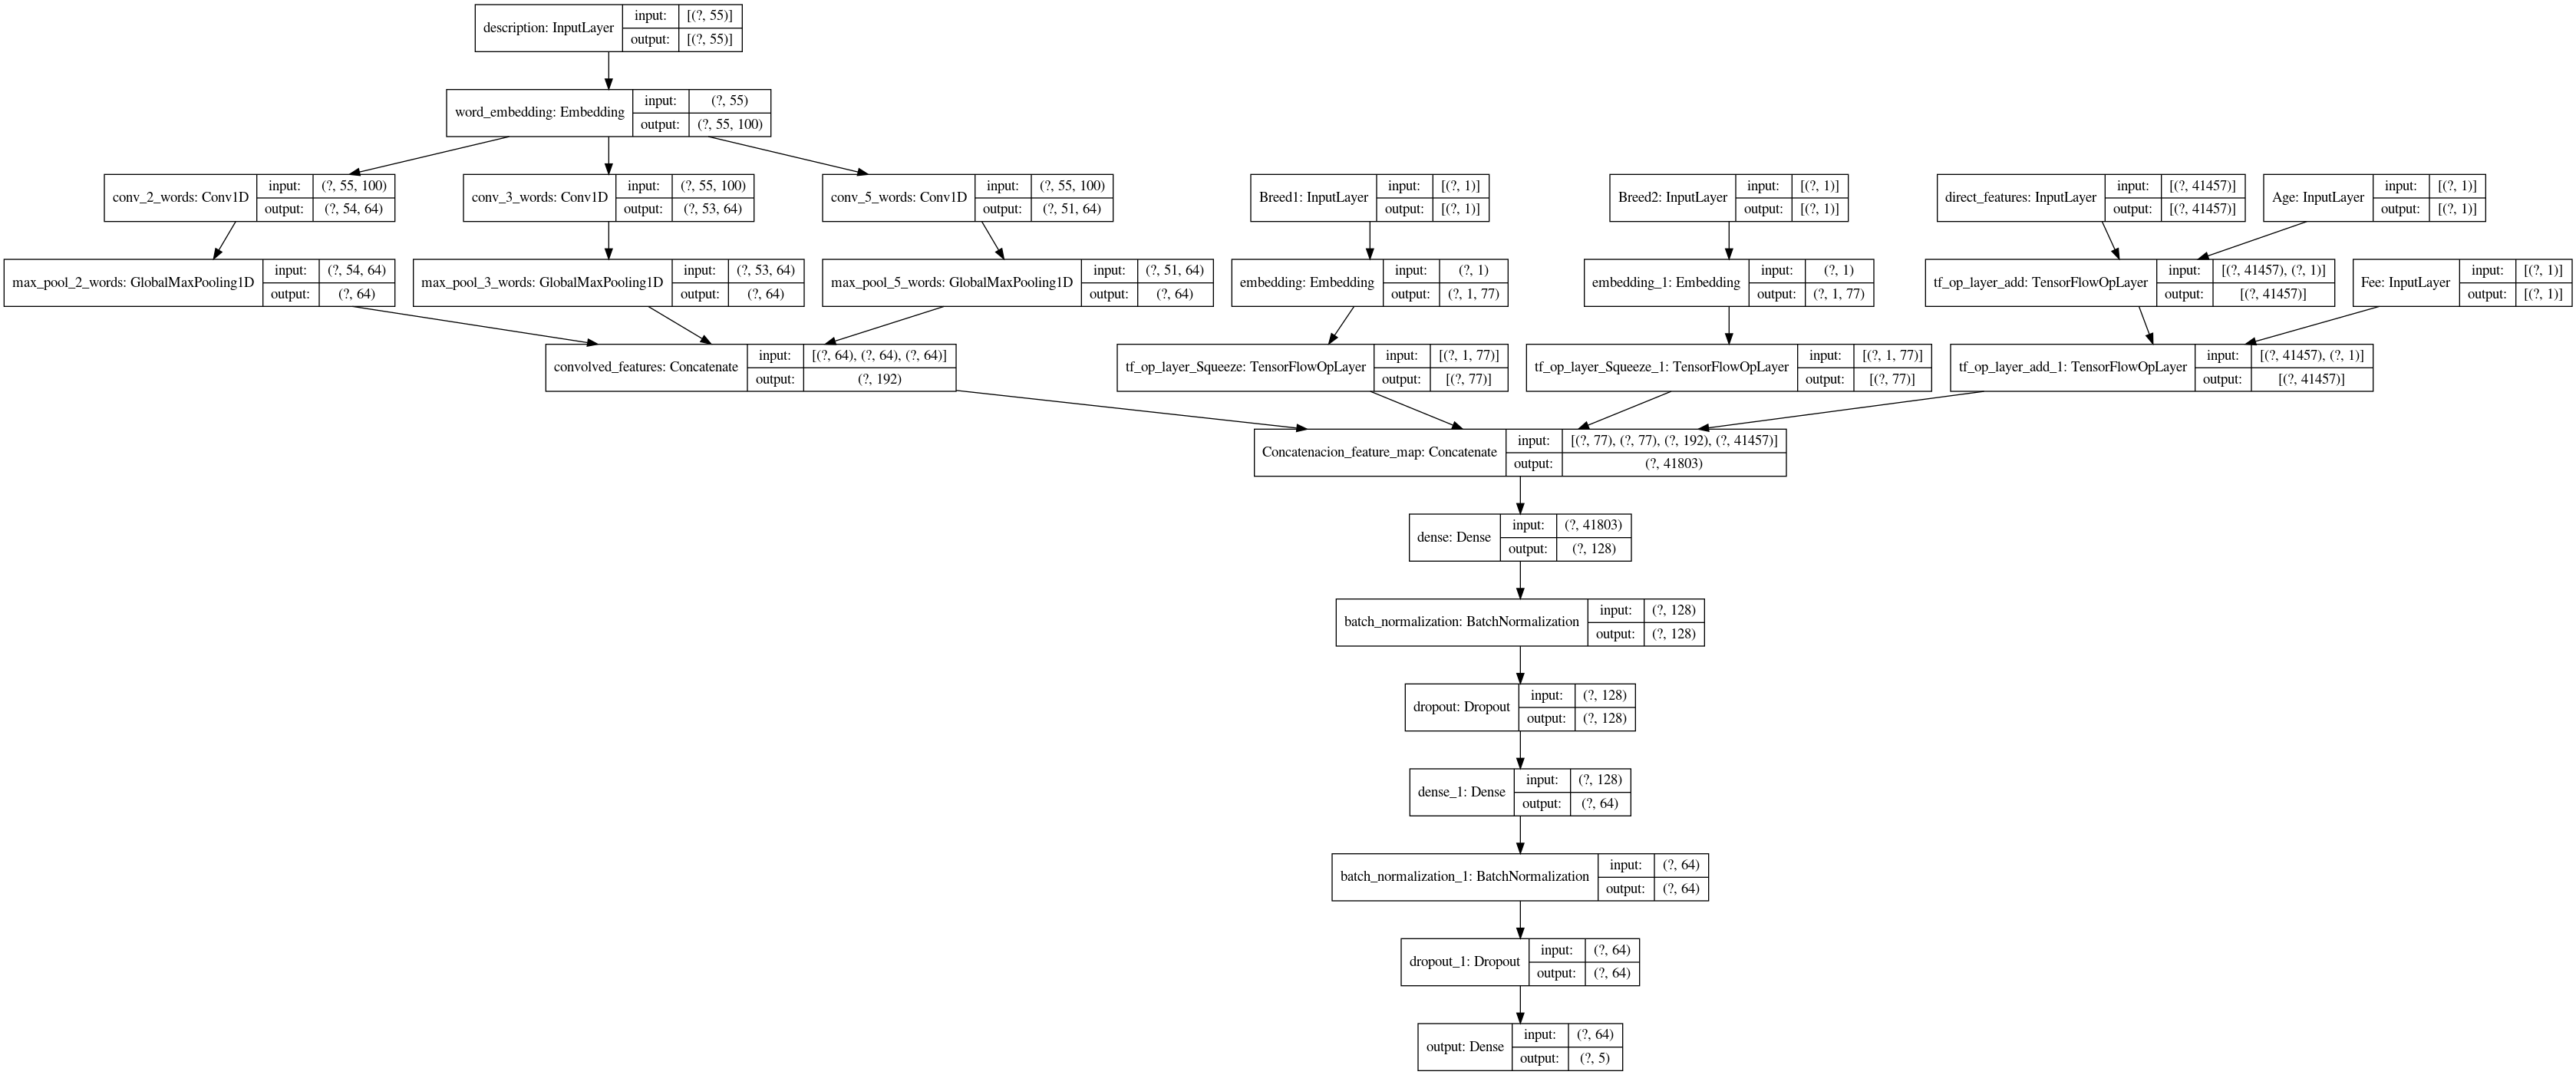

In [55]:
tf.keras.utils.plot_model(
    model,
    to_file='model_tp2.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96
)

In [47]:
#dir(model)
model._feed_input_names

['Breed1', 'Breed2', 'direct_features', 'Age', 'Fee', 'description']

## Entrenando el modelo

Para entrenar el modelo es igual al caso anterior, ya generados el conjunto de datos correspondiente. Lo entrenamos con ayuda de `mlflow`.

In [48]:
import mlflow

mlflow.set_experiment('cnn_advanced_approach')

with mlflow.start_run(nested=True):
    # Log model hiperparameters first
    #mlflow.log_param('description_features_layer_size', DESCRIPTION_FEATURES_LAYER_SIZE)
    mlflow.log_param('input_embedded_columns', embedded_columns)
    mlflow.log_param('input_one_hot_columns', one_hot_columns)
    mlflow.log_param('input_numeric_columns', numeric_columns)
    
    mlflow.log_param('hidden_layer_size_1', HIDDEN_LAYER_SIZE)
    mlflow.log_param('hidden_layer_size_2', HIDDEN_LAYER_SIZE / 2)
    mlflow.log_param('Dropout_rate_1', DROPOUT_RATE)
    mlflow.log_param('Dropout_rate_2', DROPOUT_RATE/2)
   
    mlflow.log_param('learning_rate', L2_LEARNING_RATE)
    # mlflow.log_param('numerical_columns', numerical_columns)  # Not using these yet
    
    # Train
    epochs = 10
    history = model.fit(train_dataset, epochs=epochs)
    
    # Evaluate
    loss, accuracy = model.evaluate(dev_dataset, verbose=0)
    print("\n*** Validation loss: {} - accuracy: {}".format(loss, accuracy))
    mlflow.log_metric('epochs', epochs)
    mlflow.log_metric('train_loss', history.history["loss"][-1])
    mlflow.log_metric('train_accuracy', history.history["accuracy"][-1])
    mlflow.log_metric('validation_loss', loss)
    mlflow.log_metric('validation_accuracy', accuracy)

Epoch 1/10
67/67 [==============================] - 20s 291ms/step - loss: 2.1577 - accuracy: 0.2532
Epoch 2/10
67/67 [==============================] - 17s 255ms/step - loss: 1.9319 - accuracy: 0.2706
Epoch 3/10
67/67 [==============================] - 17s 248ms/step - loss: 1.8386 - accuracy: 0.2861
Epoch 4/10
67/67 [==============================] - 16s 246ms/step - loss: 1.7867 - accuracy: 0.2913
Epoch 5/10
67/67 [==============================] - 16s 240ms/step - loss: 1.7727 - accuracy: 0.3015
Epoch 6/10
67/67 [==============================] - 16s 243ms/step - loss: 1.7398 - accuracy: 0.3080
Epoch 7/10
67/67 [==============================] - 16s 242ms/step - loss: 1.7156 - accuracy: 0.3126
Epoch 8/10
67/67 [==============================] - 17s 256ms/step - loss: 1.7307 - accuracy: 0.3125
Epoch 9/10
67/67 [==============================] - 18s 276ms/step - loss: 1.6828 - accuracy: 0.3212
Epoch 10/10
67/67 [==============================] - 18s 271ms/step - loss: 1.6700 - accura

## Evaluando el modelo sobre los datos de evaluación para la competencia

Una vez que tenemos definido nuestro modelo, el último paso es ponerlo a prueba en los datos de evaluación para generar un archivo para enviar a la competencia Kaggle.

Comenzamos cargando el conjunto de datos.

In [49]:
test_dataset = pd.read_csv(os.path.join(DATA_DIRECTORY, 'test.csv'))
test_dataset.head()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,Description,PID
0,2,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,I just found it alone yesterday near my apartm...,1
1,1,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,Their pregnant mother was dumped by her irresp...,2
2,1,0,307,0,2,1,2,7,2,1,2,2,2,1,6,0,41326,Siu Pak just give birth on 13/6/10 to 6puppies...,7
3,2,12,265,0,2,1,7,0,2,2,3,3,3,1,1,0,41326,"Very manja and gentle stray cat found, we woul...",9
4,2,3,264,0,2,1,2,5,3,3,1,1,2,1,1,50,41326,Kali is a super playful kitten who is on the g...,11


## Creamos el conjunto de datos para darle al modelo entrenado

Tenemos que preprocesar los datos de evaluación de la misma manera que preprocesamos los de entrenamiento (para que sean compatibles con lo esperado por el modelo). Por suerte, es tan simple como hacer un par de modificaciones a lo ya hecho previamente. Lo único que tenemos que tener en cuenta es que ahora el conjunto de datos no generará una etiqueta.

In [50]:
# First tokenize the description

test_dataset["TokenizedDescription"] = test_dataset["Description"]\
    .fillna(value="").apply(tokenize_description)

# Generate the basic TF dataset

tf_test_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_generator(test_dataset, True),
    output_types=instance_types  # It should have the same instance types
)

for data in tf_test_dataset.take(2):  # The dataset only returns a data instance now (no target)
    pprint(data)
    print()

{'Age': <tf.Tensor: id=7303, shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'Breed1': <tf.Tensor: id=7304, shape=(1,), dtype=int32, numpy=array([265], dtype=int32)>,
 'Breed2': <tf.Tensor: id=7305, shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'Fee': <tf.Tensor: id=7306, shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'description': <tf.Tensor: id=7307, shape=(13,), dtype=int32, numpy=
array([ 116,  429, 1371,  991,  189,    1, 7873, 1043,   62,  600,  728,
          5,    1], dtype=int32)>,
 'direct_features': <tf.Tensor: id=7308, shape=(41457,), dtype=float32, numpy=array([0., 1., 1., ..., 0., 0., 0.], dtype=float32)>}

{'Age': <tf.Tensor: id=7309, shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'Breed1': <tf.Tensor: id=7310, shape=(1,), dtype=int32, numpy=array([307], dtype=int32)>,
 'Breed2': <tf.Tensor: id=7311, shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'Fee': <tf.Tensor: id=7312, shape=(1,), dtype=float32, 

## Padding batches

Por último, y previo a probar el modelo sobre los datos de evaluación, generamos el conjunto de datos "rellenado". 

A diferencia de los datos de entrenamiento y validación, en este caso no permutamos las instancias, pues necesitamos saber a que `PID` pertenece cada una.

Por otra parte, utilizamos los mismos valores de `padding_shapes` y `padding_values` para el primer componente (el de los datos), ignorando el valor del segundo componente (el de las etiquetas).

In [51]:
test_data = tf_test_dataset.padded_batch(
    BATCH_SIZE, 
    padded_shapes=padding_shapes[0], 
    padding_values=padding_values[0]
)

## Correr el modelo

El último paso es correr el modelo sobre los datos de evaluación para conseguir las predicciones a enviar a la competencia.

In [52]:
test_dataset["AdoptionSpeed"] = model.predict(test_data).argmax(axis=1)

test_dataset.to_csv("./submission.csv", index=False, columns=["PID", "AdoptionSpeed"])